In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# We only change the input image other steps are similar.

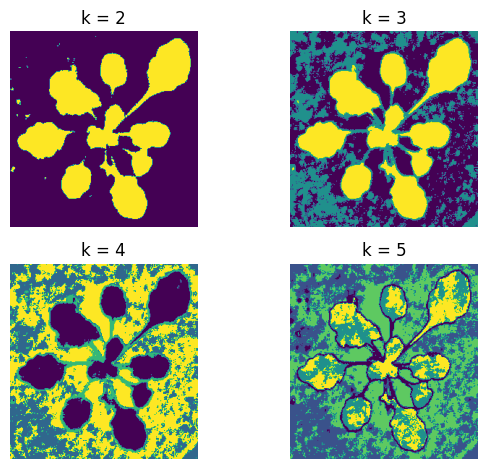

In [2]:
# Read the input image
image = cv2.imread(r"picture2.jpeg")
# Reshape the image to a 2D array of pixels
pixels = image.reshape(-1, 3).astype(np.float32)
# Perform k-means clustering for different values of k
k_values = [2, 3, 4, 5]
segmentation_results = []
for k in k_values:
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Reshape the labels to match the original image shape
    segmented_image = labels.reshape(image.shape[:2])

    # Append the segmented image to the results list
    segmentation_results.append(segmented_image)

# Display the segmentation results for each value of k
for i, segmented_image in enumerate(segmentation_results):
    plt.subplot(2, 2, i + 1)
    plt.imshow(segmented_image, cmap='viridis')
    plt.title(f"k = {k_values[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

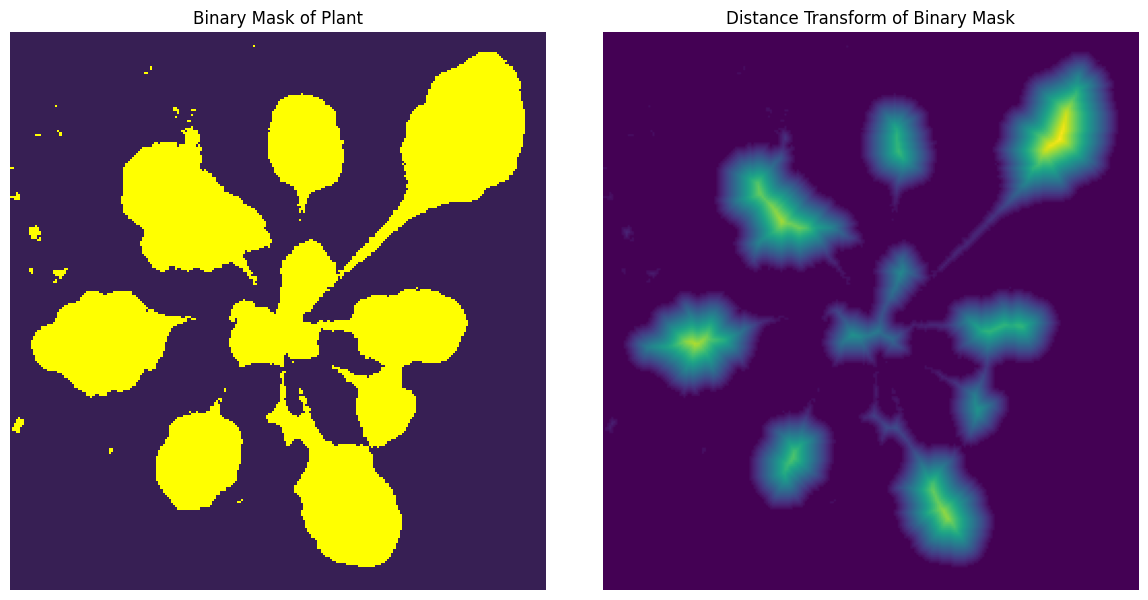

In [3]:
# Choose the segmentation result with better plant segmentation (k = 2)
chosen_segmentation = segmentation_results[0]  # k = 2 (index 0)

# Generate binary mask of the plant
binary_mask = np.where(chosen_segmentation == chosen_segmentation[0, 0], 1, 0)

# Swap the colors in the binary mask
binary_mask_swapped = np.where(binary_mask == 1, 0, 1)

# Compute distance transform of the binary mask
dist_transform = cv2.distanceTransform(binary_mask_swapped.astype(np.uint8), distanceType=cv2.DIST_L2, maskSize=3)

eggplant_rgb = (55/255, 31/255, 84/255)
# RGB values for eggplant color
colors_binary_mask = ListedColormap([eggplant_rgb, 'yellow'])

# Display the binary mask with the custom colormap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(binary_mask_swapped, cmap=colors_binary_mask, interpolation='nearest')
ax1.set_title("Binary Mask of Plant")
ax1.axis('off')

ax2.imshow(dist_transform, cmap='viridis')
ax2.set_title("Distance Transform of Binary Mask")
ax2.axis('off')

plt.tight_layout()
plt.show()

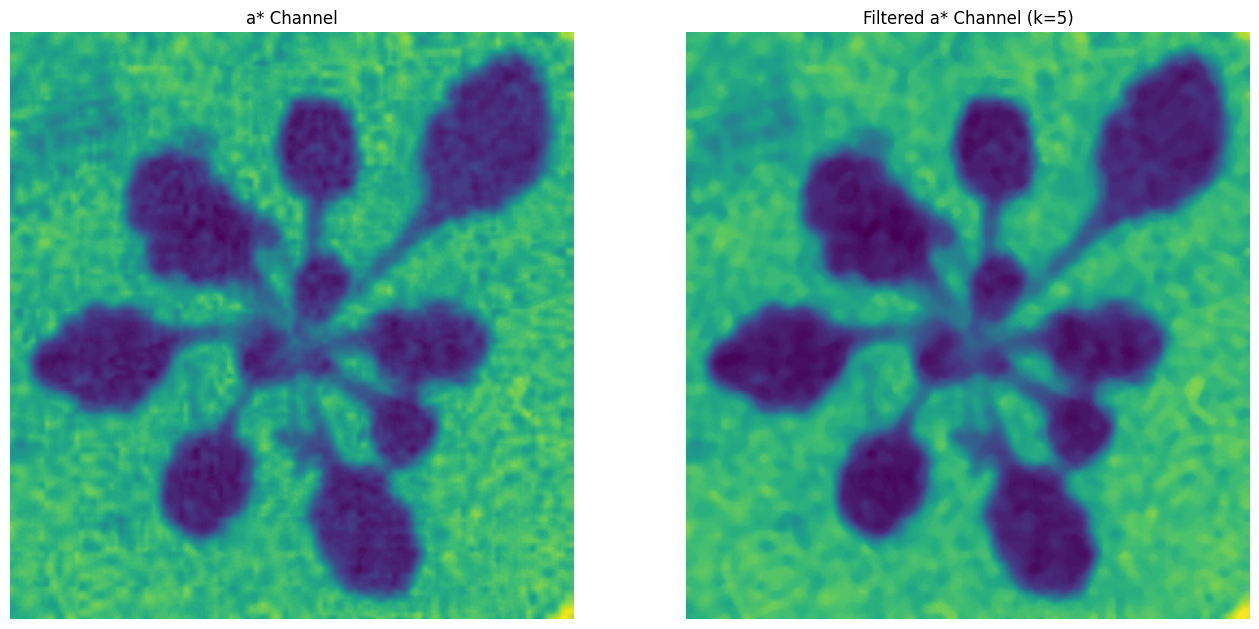

In [4]:
# Convert the input image to Lab color space
img_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

# Extract the a* channel from the Lab color space
img_a = img_lab[:, :, 1]

# Apply median filtering to the a* channel
img_a_filtered = cv2.medianBlur(img_a, ksize=5)

# Display the a* channel and the filtered a* channel
fig = plt.figure(figsize=(16, 8))
columns = 2
rows = 1

fig.add_subplot(rows, columns, 1)
plt.imshow(img_a, cmap='viridis')
plt.title("a* Channel")
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(img_a_filtered, cmap='viridis')
plt.title("Filtered a* Channel (k=5)")
plt.axis('off')

plt.show()

In [7]:
# Convert the image to Lab color space and extract the a channel
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
a_channel = lab_image[:, :, 1]

# Apply median filtering to the a channel
filtered_a = cv2.medianBlur(a_channel, ksize=5)

# Compute the distance transform of the filtered a channel
_, binary_mask = cv2.threshold(filtered_a, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Perform morphological opening to remove small noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
opened_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)

# Reverse the binary mask by inverting the colors
reversed_mask = cv2.bitwise_not(opened_mask)

# Compute the distance transform of the reversed mask
dist_transform = cv2.distanceTransform(reversed_mask, cv2.DIST_L2, 3)

# Find the maximum value in the distance transform
max_distance = np.max(dist_transform)

# Compute minRadius and maxRadius based on the maximum value
min_radius = int(0.25 * max_distance)
max_radius = int(1.25 * max_distance)

# Perform Hough circle detection with different parameter settings
param1_values = [30, 40, 40]
param2_values = [10, 10, 15]
results = []


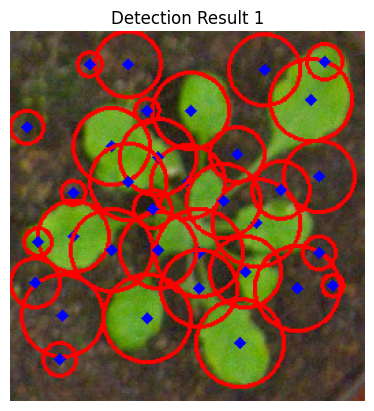

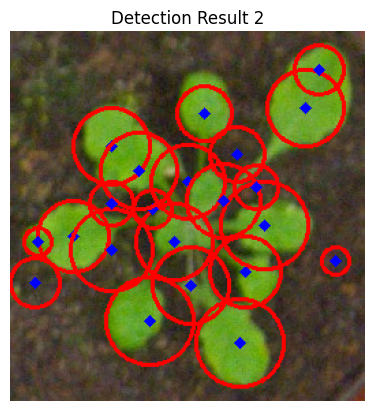

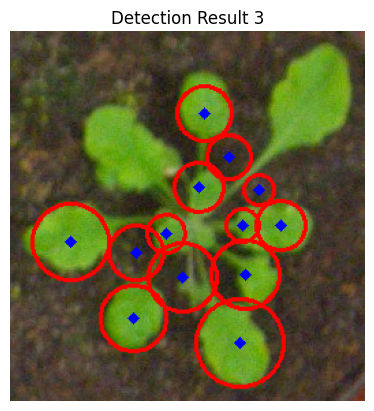

In [8]:
for param1, param2 in zip(param1_values, param2_values):
    circles = cv2.HoughCircles(filtered_a, cv2.HOUGH_GRADIENT, dp=1, minDist=int(0.1 * min(image.shape[:2])),
                               param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)
    if circles is not None:
        circles = np.round(circles[0, :]).astype(int)
    results.append(circles)

# Visualize the detected circles and their corresponding parameters
for i, circles in enumerate(results):
    output_image = image.copy()
    if circles is not None:
        for (x, y, r) in circles:
            cv2.circle(output_image, (x, y), r, (0, 0, 255), 2)
            cv2.circle(output_image, (x, y), 2, (255, 0, 0), 3)

    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Detection Result {i + 1}")
    plt.axis('off')
    plt.show()


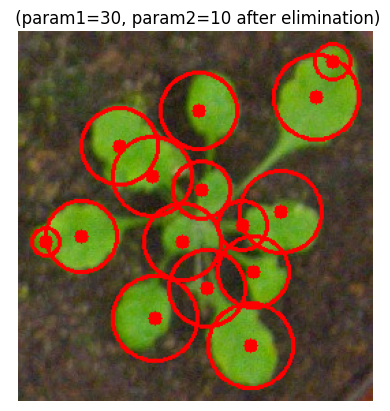

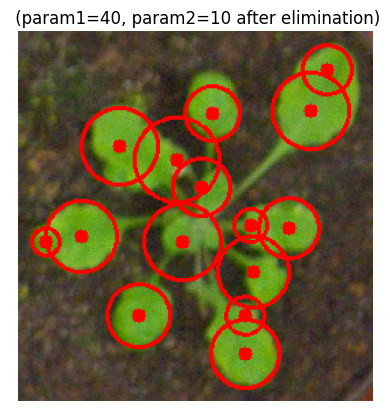

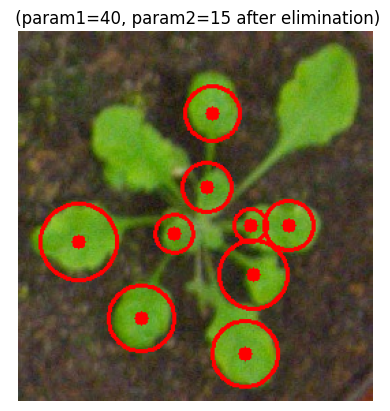

In [4]:
# Convert the image to the Lab color space
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

# Extract the a* channel
a_channel = lab_image[:, :, 1]

# Apply median filtering to the a* channel
filtered_a = cv2.medianBlur(a_channel, 5)

# Compute the distance transform of the binary mask
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, binary_mask = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
distance_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 3)

# Find the maximum value in the distance transform
max_distance = np.max(distance_transform)

# Find the value of the distance transform at the centers of smaller leaves
y_center = 100  # Replace with the actual y-coordinate of the center of a smaller leaf
x_center = 200  # Replace with the actual x-coordinate of the center of a smaller leaf
center_distance = distance_transform[y_center, x_center]

# Determine minRadius and maxRadius based on the distance transform values
min_radius = int(center_distance)
max_radius = int(1.25 * max_distance)

# Parameter settings for HoughCircles
param1_values = [30, 40, 40]
param2_values = [10, 10, 15]

# Define colors for different leaves
colors = [(0, 0, 255), (0, 0, 255), (0, 0, 255)]

# Detect circles using HoughCircles for each parameter setting
for i in range(len(param1_values)):
    param1 = param1_values[i]
    param2 = param2_values[i]

    # Detect circles using HoughCircles
    circles = cv2.HoughCircles(filtered_a, cv2.HOUGH_GRADIENT, dp=1, minDist=0.1 * min(image.shape[:2]),
                               param1=param1, param2=param2, minRadius=min_radius, maxRadius=max_radius)

    # Visualize the detected circles and middle points as different colors
    if circles is not None:
        circles = np.round(circles[0, :]).astype(int)
        output_image = image.copy()
        for (x, y, r) in circles:
            # Check if the circle's center is inside the plant mask
            if binary_mask[y, x] == 255:
                # Draw the circle with its respective color
                cv2.circle(output_image, (x, y), r, colors[i], 2)
                # Draw the middle point with a different color
                cv2.circle(output_image, (x, y), 5, colors[i], -1)

        # Display the image with detected circles and corresponding parameters
        plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
        plt.title(f" (param1={param1}, param2={param2} after elimination)")
        plt.axis('off')
        plt.show()

cv2.destroyAllWindows()
